In [1]:
from math import log2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torch.utils.tensorboard import SummaryWriter # print to tensorboard
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors


from src.models.utils.create_batch import EarthDataTrain
from src.models.model.model import Generator, Discriminator, init_weights
from src.models.loss.wasserstein import gradient_penalty

# to clear outputs from cells
from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def plot_fake_truth(fake, x_truth):
    plt.switch_backend('agg')    
    with torch.no_grad():
        fake = gen(x_input).cpu()
        x_truth = x_truth.cpu()
        color_scheme='inferno'
        no_col = 10
        fig, ax = plt.subplots(2,no_col, figsize=(18,8))
        b, v, r, h, w = fake.shape
        for i in range(no_col):
            bi = torch.randint(b,(1,)).item()
            vi = torch.randint(v,(1,)).item()
            ri = torch.randint(r,(1,)).item()
            ax[0,i].pcolormesh(fake[bi,vi,ri,:,:].cpu(), cmap=color_scheme)
            ax[0,i].get_xaxis().set_visible(False)
            ax[0,i].get_yaxis().set_visible(False)
            ax[0,i].title.set_text(f'v={vi}, r={ri}')
            ax[1,i].pcolormesh(x_truth[bi,vi,ri,:,:].cpu(), cmap=color_scheme)
            ax[1,i].get_xaxis().set_visible(False)
            ax[1,i].get_yaxis().set_visible(False)
        plt.subplots_adjust(wspace=0, hspace=0)
        
    return fig

In [4]:


#######################################################
# Set Hyperparameters
#######################################################

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

LEARNING_RATE = 1e-4
NUM_EPOCHS = 2
BATCH_SIZE = 2
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
GEN_PRETRAIN_EPOCHS= 80 # number of epochs to pretrain generator

#######################################################

# set summary writer for Tensorboard
writer_results = SummaryWriter(f"logs/results")
step = 0

root_dir = Path.cwd().parent.parent # set the root directory as a Pathlib path

path_input_folder = root_dir / 'data/processed/input'
path_truth_folder = root_dir / 'data/processed/truth'

earth_dataset = EarthDataTrain(path_input_folder, path_truth_folder)

loader = DataLoader(
    earth_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

gen = Generator(in_chan=4, out_chan=4, scale_factor=8, chan_base=32, chan_min=32, chan_max=64, cat_noise=True).to(device)
critic = Discriminator(in_chan=8, out_chan=8, scale_factor=8, chan_base=32, chan_min=32, chan_max=64).to(device)

# initialize weights
gen.apply(init_weights)
critic.apply(init_weights)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.0, 0.9))

gen.train()
critic.train()


for epoch in range(NUM_EPOCHS):
    print('epoch', epoch)


    for batch_idx, data in enumerate(loader):
        x_truth = data['truth'].to(device)
        x_up = data['upsampled'].to(device)
        x_input = data['input'].to(device)

        # pre-train the generator with simple MSE loss
        if epoch < GEN_PRETRAIN_EPOCHS:
            criterion = nn.MSELoss()
            gen_fake = gen(x_input)
            loss_mse = criterion(gen_fake, x_truth)
            gen.zero_grad()
            loss_mse.backward()
            opt_gen.step()

        # after pre-training of generator, enter the 
        # full training loop and train critic (e.g. discriminator) too
        else:
            # train critic
            for _ in range(CRITIC_ITERATIONS):
                fake = gen(x_input)
                critic_real = critic(torch.cat([x_truth, x_up], dim=1)).view(-1)
                critic_fake = critic(torch.cat([fake, x_up], dim=1)).view(-1)
                
                gp = gradient_penalty(critic, 
                                    torch.cat([x_truth, x_up], dim=1), # real
                                    torch.cat([fake, x_up], dim=1),  # fake
                                    device=device)

                loss_critic = (
                        -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
                    )
                
                critic.zero_grad()
                loss_critic.backward(retain_graph=True)
                opt_critic.step()

            # train generator after every N critic iterations
            gen_fake = critic(torch.cat([fake, x_up], dim=1)).reshape(-1)
            loss_gen = -torch.mean(gen_fake)
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()
        with torch.no_grad():
            fake = gen(x_input)
            fig = plot_fake_truth(fake, x_truth)
            writer_results.add_figure("Results", fig, global_step=step)

        step += 1
            
clear_output(wait=False)

/tmp/ipykernel_11512/1643197932.py:42: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


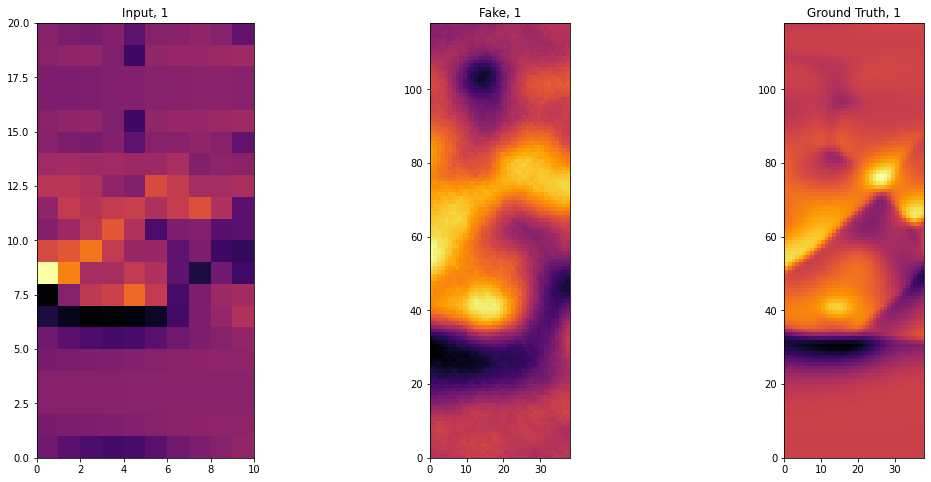

In [38]:
# randomly select image
data = earth_dataset[0]
x_input = data['input'].unsqueeze(0).to(device)
x_truth = data['truth'].unsqueeze(0).to(device)

with torch.no_grad():
    fake = gen(x_input).detach()

    
title_list = ['Input', "Fake", 'Ground Truth']
r_index = 1
var_to_plot = 3
    
# create image
color_scheme='inferno'
fig, axes = plt.subplots(1,3, figsize=(18,8))

for ax, title in zip(axes.flat, title_list):
    
                
    # downscaled data
    if title == 'Input':
                                
        ax.pcolormesh(x_input[0,var_to_plot,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)
                
    # downscaled data
    if title == 'Fake':
                
        ax.pcolormesh(fake[0,var_to_plot,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)
            
    # original data
    if title == 'Ground Truth':
           
        img = ax.pcolormesh(x_truth[0,var_to_plot,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)

plt.show()